# **IMPORTING REQUIRED LIBRARIES**





In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from google.colab import files
import os
import zipfile

from glob import glob
from PIL import Image as pil_image
from matplotlib.pyplot import imshow, imsave
from IPython.display import Image as Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.utils.np_utils import to_categorical
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD
from keras import regularizers, initializers
from keras.layers.advanced_activations import LeakyReLU, ReLU, Softmax
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.merge import concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import *
from keras.utils import plot_model
from keras.models import load_model


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **IMPORTING KAGGLE API**

In [ ]:
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

import kaggle
print("Imported kaggle API successfully !")

Saving kaggle.json to kaggle (2).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
Imported kaggle API successfully !


# **DOWNLOADING HAM10000 DATASET FROM KAGGLE**

In [ ]:
print("Downloading dataset : ")
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000/downloads/skin-cancer-mnist-ham10000.zip
print("Downloaded Successfully!")

100% 5.20G/5.20G [01:49<00:00, 50.3MB/s]
100% 5.20G/5.20G [01:49<00:00, 51.2MB/s]
Downloaded Successfully!


# **EXTRACTING DATASET AND REMOVING UNWANTED FILES**

In [ ]:
zip_ref = zipfile.ZipFile('skin-cancer-mnist-ham10000.zip', 'r')
zip_ref.extractall()
zip_ref.close()
os.unlink('skin-cancer-mnist-ham10000.zip')

In [ ]:
print('Moving Images into single directory')
CREATING IMAGE DIRECTORY
os.mkdir('images')
# MOVING FILES TO IMAGE FOLDER
import shutil 
destination = "/content/images"
source1 = "/content/HAM10000_images_part_1"
source2 = "/content/HAM10000_images_part_2"

dest1 = shutil.move(source1, destination)

dest2 = shutil.move(source2, destination)

Moving Images into single directory


In [ ]:
li = ['hmnist_8_8_RGB.csv',
 'hmnist_8_8_L.csv',
 'hmnist_28_28_RGB.csv',
 'hmnist_28_28_L.csv']
for i in li:
    os.unlink(i)

In [ ]:
# PRINTING FILES IN THE DIRECTORY
os.listdir()

['.config',
 'kaggle (1).json',
 'HAM10000_images_part_2',
 'kaggle (2).json',
 'CLR',
 'HAM10000_metadata.csv',
 'HAM10000_images_part_1',
 'ham10000_images_part_1',
 'model.h5',
 'ham10000_images_part_2',
 'accum_optimizer_for_keras',
 'kaggle.json',
 'images',
 'simple_model_plot.png',
 'test.jpg',
 'sample_data']

# **DATA ANALYSIS**

In [ ]:
# LOADING THE DATASET CSV IN PANDAS DATAFRAME
main_df = pd.read_csv('HAM10000_metadata.csv')
main_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


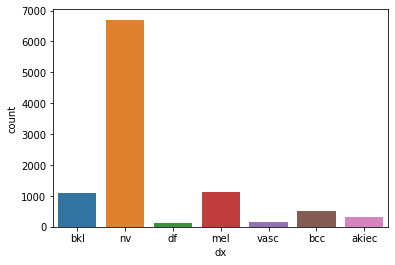

In [ ]:
sns.countplot(main_df['dx'])

In [ ]:
main_df['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

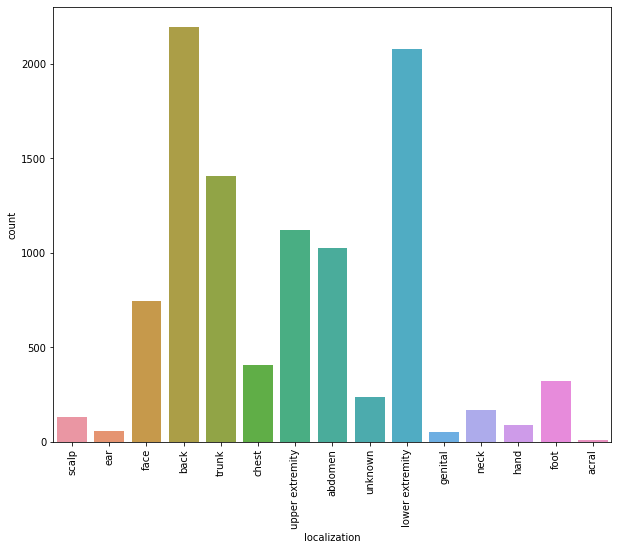

In [ ]:
plt.figure(figsize=(10,8))
sns.countplot(main_df['localization'])
plt.xticks(rotation=90)

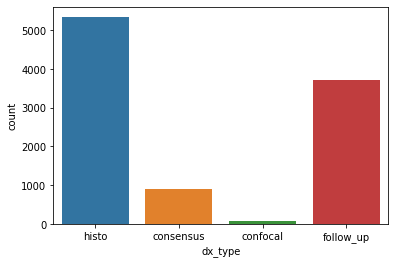

In [ ]:
sns.countplot(main_df['dx_type'])

In [ ]:
main_df['dx_type'].value_counts()

histo        5340
follow_up    3704
consensus     902
confocal       69
Name: dx_type, dtype: int64

In [ ]:
# FINDING THE NUMBER OF MISSING VALUES 
main_df.isna().sum().sort_values(ascending=False)

age             57
localization     0
sex              0
dx_type          0
dx               0
image_id         0
lesion_id        0
dtype: int64

In [ ]:
print(main_df['age'].mean())
print(main_df['age'].median())
main_df['age'].fillna(main_df['age'].mean(),inplace=True)

51.863828077927295
50.0


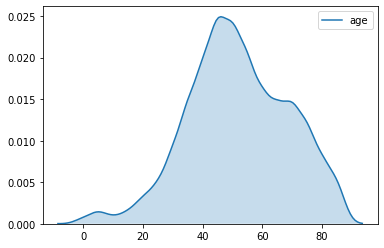

In [ ]:
sns.kdeplot(main_df['age'],shade=True)

In [ ]:
main_df['sex'].value_counts()

male       5406
female     4552
unknown      57
Name: sex, dtype: int64

In [ ]:
# CREATING A DICTIONARY TO FEED IN LABEL VALUES IN OUR DATAFRAME
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

lesion_classes_dict = {
    0: 'Melanocytic nevi',
    1: 'Melanoma',
    2: 'Benign keratosis-like lesions ',
    3: 'Basal cell carcinoma',
    4: 'Actinic keratoses',
    5: 'Vascular lesions',
    6: 'Dermatofibroma'
}

main_df['cell_type'] = main_df['dx'].map(lesion_type_dict)

In [ ]:
  main_df['cell_type_idx'] = pd.Categorical(main_df['cell_type']).codes

In [ ]:
# CREATING IMAGE PATH
image_path = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join('', '*', '*.jpg'))}

In [ ]:
main_df['path'] = main_df['image_id'].map(image_path.get)
main_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,ham10000_images_part_1/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,ham10000_images_part_1/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,ham10000_images_part_1/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,ham10000_images_part_1/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2,ham10000_images_part_2/ISIC_0031633.jpg


In [ ]:
image_example = np.asarray(pil_image.open(main_df['path'][0]))

In [ ]:
image_example.shape

(450, 600, 3)

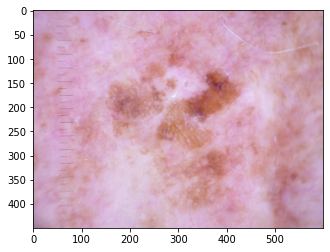

In [ ]:
# PRINTING A SAMPLE IMAGE
plt.imshow(image_example)

In [ ]:
# RESIZING THE IMAGE TO SMALLER SIZE TO MAKE TRAINING EASY
main_df['image'] = main_df['path'].map(lambda x: np.asarray(pil_image.open(x).resize((120,90))))

In [ ]:
main_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,path,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,ham10000_images_part_1/ISIC_0027419.jpg,"[[[190, 152, 194], [192, 155, 197], [191, 154,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,ham10000_images_part_1/ISIC_0025030.jpg,"[[[24, 13, 22], [24, 14, 23], [24, 14, 26], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,ham10000_images_part_1/ISIC_0026769.jpg,"[[[185, 126, 135], [189, 133, 145], [192, 135,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,ham10000_images_part_1/ISIC_0025661.jpg,"[[[24, 11, 17], [25, 11, 20], [31, 16, 27], [4..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2,ham10000_images_part_2/ISIC_0031633.jpg,"[[[131, 89, 111], [143, 98, 121], [153, 108, 1..."


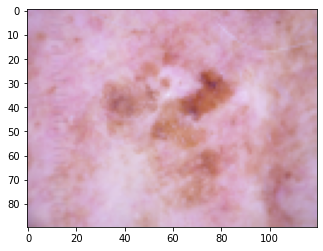

In [ ]:
plt.imshow(main_df['image'][0])

In [ ]:
main_df['image'][0].shape

(90, 120, 3)

# **PRINTING IMAGES OF EACH CLASS**

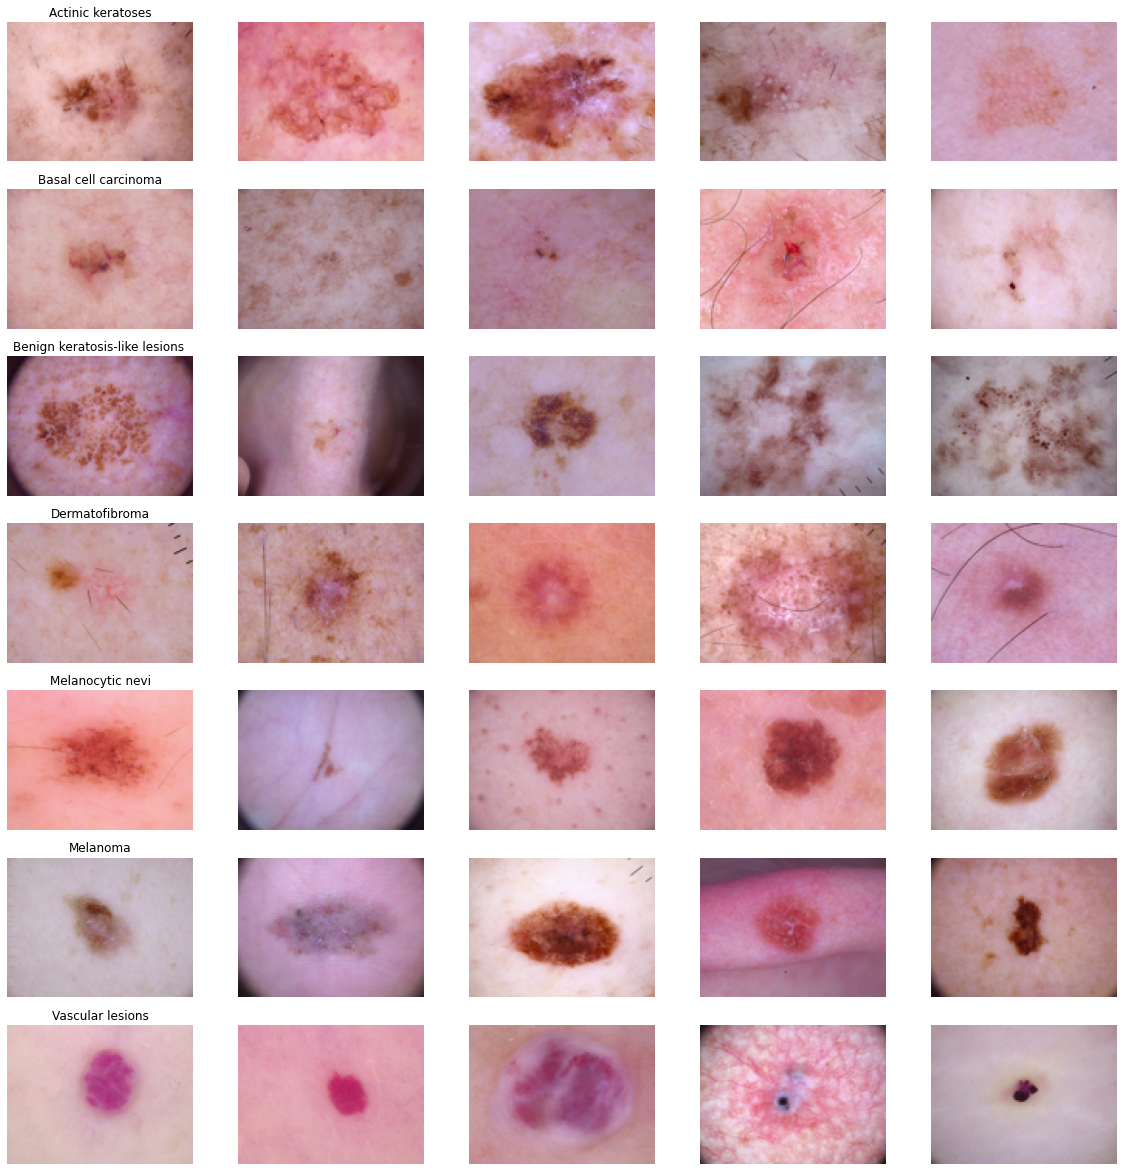

In [ ]:

fig,axes = plt.subplots(7,5,figsize=(20,21))
for nth_axis,(cell_type_name,cell_type_row) in zip(axes,main_df.sort_values(['cell_type']).groupby('cell_type')):
    nth_axis[0].set_title(cell_type_name)
    for column_axis,(_,column_row) in zip(nth_axis,cell_type_row.sample(5).iterrows()):
        column_axis.imshow(column_row['image'])  
        column_axis.axis('off')

# **DATA PROCESSING AND MODELING**

In [ ]:
features = main_df.drop(['cell_type_idx'],axis=1)

target = main_df['cell_type_idx']

# SPLITTING THE DATASETS INTO TRAIN AND TEST SET
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(features,target,test_size=0.01)

In [ ]:
# CREATING IMAGE TRAINING AND TEST SET
x_train = np.asarray(X_TRAIN['image'].tolist())
x_test = np.asarray(X_TEST['image'].tolist())

In [ ]:
print(x_train.shape)
print(x_test.shape)

(9914, 90, 120, 3)
(101, 90, 120, 3)


In [ ]:
train_mean = x_train.mean()
train_std = x_train.std()
test_mean = x_test.mean()
test_std = x_test.std()

In [ ]:
print(train_mean)
print(train_std)
print(test_mean)
print(test_std)

159.82919845236938
46.458869099760705
158.62542018090699
45.97606797757238


# **IMAGE STANDARDIZATION**

In [ ]:
x_train = (x_train-train_mean) / train_std
x_test = (x_test-test_mean) / test_std

In [ ]:
print(Y_TRAIN.shape)
print(Y_TEST.shape)

(9914,)
(101,)


In [ ]:
# CONVERTING NX1 TO NX7 SINCE WE HAVE 7 CLASSES 
y_train = to_categorical(Y_TRAIN,num_classes=7)
y_test = to_categorical(Y_TEST,num_classes=7)

In [ ]:
print(y_train.shape)
print(y_test.shape)

(9914, 7)
(101, 7)


In [ ]:
X_train,X_val, Y_train,Y_val = train_test_split(x_train,y_train,test_size=0.15)

In [ ]:
# RESHAPING SO THAT WE CAN FEED THIS INTO OUR NEURAL NETWORK
X_train  = X_train.reshape(X_train.shape[0],90,120,3)
x_test  = x_test.reshape(x_test.shape[0],90,120,3)
X_val  = X_val.reshape(X_val.shape[0],90,120,3)

In [ ]:
print(X_train.shape)
print(x_test.shape)
print(X_val.shape)

(8426, 90, 120, 3)
(101, 90, 120, 3)
(1488, 90, 120, 3)


# **MODEL**

In [ ]:
# COMMAND TO INSTALL KERAS OPTIMIZERS
!pip install -q efficientnet
!git clone https://github.com/bckenstler/CLR.git
!pip install -q keras-radam
!git clone https://github.com/bojone/accum_optimizer_for_keras.git
!pip install -q keras-lr-multiplier

fatal: destination path 'CLR' already exists and is not an empty directory.
fatal: destination path 'accum_optimizer_for_keras' already exists and is not an empty directory.


In [ ]:
# IMPORTING THE EFFICIENTNETB3 MODEL
import tensorflow as tf
import keras
import efficientnet.tfkeras as efn

In [ ]:
# INITIALIZING THE MODEL
model = efn.EfficientNetB3(weights ='noisy-student', include_top=False,
                           input_shape = (90, 120, 3))

In [ ]:
# IMPORTING LIBRARIES
from tensorflow.keras.layers import GlobalAveragePooling2D,Dropout,Dense
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential,Model

In [ ]:
# MAKING CHANGES IN THE OUTPUT LAYER OF EFFICIENTNETB3 MODEL
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(7, activation="softmax")(x)
model = Model(inputs=model.input, outputs=predictions)

In [ ]:
# COMPILING THE MODEL
model.compile(optimizer = Adam(0.001) , loss = "categorical_crossentropy", metrics=['accuracy'])

In [ ]:
# SET A LEARNING RATE ANNEALER
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3, 
                                            factor=0.5, 
                                            min_lr=0.000001)

# **TRAINING THE DATA**

In [ ]:
# WITH DATA AUGMENTATION TO PREVENT OVERFITTING

datagen = ImageDataGenerator(
        rotation_range=10,  # RANDOMLY ROTATE IMAGES IN THE RANGE (0 - 180)
        zoom_range = 0.1 # RANDOMLY ZOOM IMAGES 
)


# FIT THE MODEL
epochs = 20
batch_size = 16
model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/20
526/526 [==============================] - 100s 191ms/step - loss: 0.2508 - accuracy: 0.9149 - val_loss: 0.6234 - val_accuracy: 0.7957
Epoch 2/20
526/526 [==============================] - 97s 185ms/step - loss: 0.2652 - accuracy: 0.9112 - val_loss: 0.7264 - val_accuracy: 0.7997
Epoch 3/20
526/526 [==============================] - 97s 185ms/step - loss: 0.2602 - accuracy: 0.9118 - val_loss: 0.6976 - val_accuracy: 0.7964
Epoch 4/20
526/526 [==============================] - 97s 185ms/step - loss: 0.2447 - accuracy: 0.9162 - val_loss: 0.6855 - val_accuracy: 0.7991
Epoch 5/20
526/526 [==============================] - 97s 184ms/step - loss: 0.1325 - accuracy: 0.9545 - val_loss: 0.6566 - val_accuracy: 0.8259
Epoch 6/20
526/526 [==============================] - 97s 185ms/step - loss: 0.0953 - accuracy: 0.9680 - val_loss: 0.6385 - val_accuracy: 0.8259
Epoch 7/20
526/526 [==============================] - 97s 185ms/step - loss: 0.0903 - accuracy: 0.9707 - val_loss: 0.7061 - val_a

# **PLOTTING GRAPH**

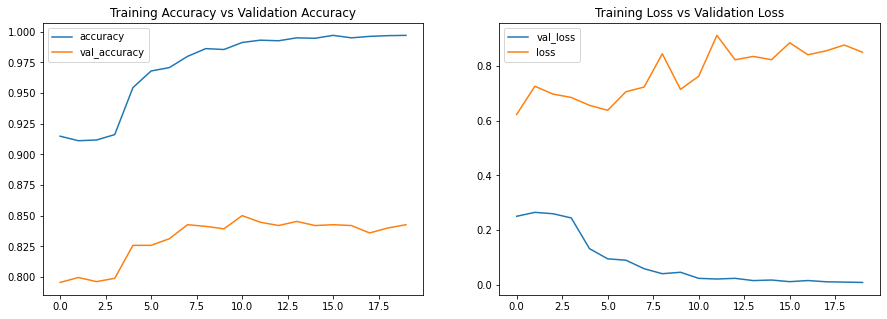

In [ ]:
def plot_(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    f, [ax1, ax2] = plt.subplots(1,2, figsize=(15, 5))
    ax1.plot(range(len(acc)), acc, label="accuracy")
    ax1.plot(range(len(acc)), val_acc, label="val_accuracy")
    ax1.set_title("Training Accuracy vs Validation Accuracy")
    ax1.legend()

    ax2.plot(range(len(loss)), loss, label="loss")
    ax2.plot(range(len(loss)), val_loss, label="val_loss")
    ax2.set_title("Training Loss vs Validation Loss")
    ax2.legend()
    
    
plot_(model.history)

In [ ]:
# PRINTING THE ACCURACY OF THE MODEL
print("MAXIMUM ACCURACY : ",
      round(max(model.history.history["val_accuracy"])*100,4))

MAXIMUM ACCURACY :  85.0134


# **SAVING THE MODEL**

In [ ]:
model.save("model.h5")

# **PREDICTION OF IMAGE**

Original Shape of image is :  (372, 662, 3)


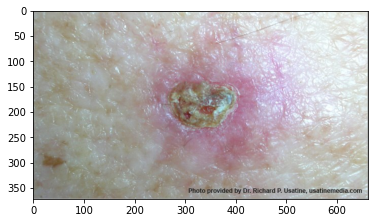

In [ ]:
# RANDOMLY DOWNLOAD A IMAGE FROM INTERNET TO TEST THE MODEL 
import urllib

url="https://www.cancer.org/cancer/skin-cancer/skin-cancer-image-gallery/_jcr_content/par/section/parsys/responsive_columns/column-0/gallery/parsys/responsive_columns_1/column-0/gallery_image_copy_c/image.img.jpg/1497970742037.jpg"
urllib.request.urlretrieve(url,'test.jpg')
test_image = np.asarray(pil_image.open('test.jpg'))
print('Original Shape of image is : ',test_image.shape)
plt.imshow(test_image)

In [ ]:
# RESIZING THE IMAGE
resized_image = np.asarray(pil_image.open('test.jpg').resize((120,90)))
image_array = np.asarray(resized_image.tolist())
test_image = image_array.reshape(1,90,120,3)

In [ ]:
prediction_class = model.predict(test_image)
prediction_class = np.argmax(prediction_class,axis=1)


In [ ]:
prediction_class

array([3])

In [ ]:
# PREDICTING THE IMAGE
lesion_classes_dict[prediction_class[0]]

'Basal cell carcinoma'